In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.simplefilter('ignore')

import shap

In [2]:
original_df= pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
original_df_test=pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
original_df_sample =pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
original_data = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')


df= pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test=pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
df_sample =pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
original = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')

In [3]:
def check_columns(df, df_test):
    extra_columns_df = [col for col in df.columns if col not in df_test.columns]
    extra_columns_df_test = [col for col in df_test.columns if col not in df.columns]
    if extra_columns_df or extra_columns_df_test:
        print("Extra_columns_in_df",extra_columns_df)
        '''print(extra_columns_df_test)'''
    else:
        return None


def check_columns_dtype(df,df_test):
    print(df.dtypes.value_counts())
    print()
    print(df_test.dtypes.value_counts())
    print()


def to_predict(df_sample):
    print("We have to predict the:",df_sample.columns)
    
    
    
def check_null_values(df,df_test):
    print("NUll values in the df:"), print(df.isnull().sum()),print()
    print("Null values in the df_test:"),print(df_test.isnull().sum())
    

                                         
'''MAIN CDOE'''        

df= pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test=pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
df_sample =pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

check_columns(df, df_test), print(),print()

check_columns_dtype(df,df_test),print()

to_predict(df_sample), print(), print()

check_null_values(df,df_test)
    

Extra_columns_in_df ['loan_status']


int64      6
object     4
float64    3
Name: count, dtype: int64

int64      5
object     4
float64    3
Name: count, dtype: int64


We have to predict the: Index(['id', 'loan_status'], dtype='object')


NUll values in the df:
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Null values in the df_test:
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate        

In [4]:
df.nunique(dropna=True)

id                            58645
person_age                       53
person_income                  2641
person_home_ownership             4
person_emp_length                36
loan_intent                       6
loan_grade                        7
loan_amnt                       545
loan_int_rate                   362
loan_percent_income              61
cb_person_default_on_file         2
cb_person_cred_hist_length       29
loan_status                       2
dtype: int64

In [5]:
objects = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for idx in objects:
    print(f"Unique_Values in {idx}: {df[idx].nunique(dropna=True)}")

Unique_Values in person_home_ownership: 4
Unique_Values in loan_intent: 6
Unique_Values in loan_grade: 7
Unique_Values in cb_person_default_on_file: 2


In [6]:
# df = df.drop('id', axis=1)
# df_test = df_test.drop('id', axis=1)
train = original_df
test = original_df_test

In [7]:
def add_shuffled(df, col):
    df[f'{col}_shuffled'] = df[col].sample(frac=1).reset_index(drop=True)
    return df

In [8]:
df = pd.concat([train, test])
# to_shuffle = ["loantoincome", "loan_percent_incometoincome", "cb_person_cred_hist_lengthtoincome", 'person_age_to_person_income', 
#               'person_emp_length_to_cb_person_cred_hist_length', 'person_emp_length_to_person_age', 'loan_int_rate_to_loan_amnt',
#               "person_home_ownership_income", "loan_intent_income", "loan_grade_income"]

# featrue engineering
df["loantoincome"] = ((df["loan_amnt"] / df["person_income"])).astype(str).astype('category')
df["loan_percent_incometoincome"] = ((df["loan_percent_income"] / df["person_income"])).astype(str).astype('category')
# df["cb_person_cred_hist_lengthtoincome"] = ((df["cb_person_cred_hist_length"] / df["person_income"])).astype(str).astype('category')
df['person_age_to_person_income'] = (df['person_age'] / df['person_income']).astype(str).astype('category')
# df['person_emp_length_to_cb_person_cred_hist_length'] = (df['person_emp_length'] / df['cb_person_cred_hist_length']).astype(str).astype('category')
df['person_emp_length_to_person_age'] = (df['person_emp_length'] / df['person_age']).astype(str).astype('category')
df['loan_int_rate_to_loan_amnt'] = (df['loan_int_rate'] / df['loan_amnt']).astype(str).astype('category')

df['person_home_ownership'] = df['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
df['loan_intent'] = df['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
df['loan_grade'] = df['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}).astype('category')
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')
df['person_emp_length'] = df['person_emp_length'].astype(str).astype('category')
df['loan_int_rate'] = (df['loan_int_rate'] * 100).astype(str).astype('category')
df['loan_percent_income'] = (df['loan_percent_income'] * 100).astype(str).astype('category')

# more feature engineering
df["person_home_ownership_income"] = pd.Series(pd.factorize((df["person_home_ownership"].astype(str) + df["person_income"].astype(str)).to_numpy())[0]).astype('category')
# df["loan_intent_income"] = pd.Series(pd.factorize((df["loan_intent"].astype(str) + df["person_income"].astype(str)).to_numpy())[0]).astype('category')
# df["loan_grade_income"] = pd.Series(pd.factorize((df["loan_grade"].astype(str) + df["person_income"].astype(str)).to_numpy())[0]).sample(frac=1).reset_index(drop=True).astype('category')

# Shuffle
# for col in to_shuffle:
#     add_shuffled(df, col)

train = df[:train.shape[0]]
test = df[train.shape[0]:]

train

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loantoincome,loan_percent_incometoincome,person_age_to_person_income,person_emp_length_to_person_age,loan_int_rate_to_loan_amnt,person_home_ownership_income
0,0,37,35000,0,0.0,0,1,6000,1149.0,17.0,0,14,0.0,0.17142857142857143,4.857142857142858e-06,0.0010571428571428572,0.0,0.001915,0
1,1,22,56000,2,6.0,1,2,4000,1335.0,7.000000000000001,0,2,0.0,0.07142857142857142,1.25e-06,0.0003928571428571429,0.2727272727272727,0.0033374999999999998,1
2,2,29,28800,2,8.0,2,0,6000,890.0,21.0,0,10,0.0,0.20833333333333334,7.291666666666667e-06,0.0010069444444444444,0.27586206896551724,0.0014833333333333335,2
3,3,30,70000,0,14.0,3,1,12000,1111.0,17.0,0,5,0.0,0.17142857142857143,2.428571428571429e-06,0.00042857142857142855,0.4666666666666667,0.0009258333333333333,3
4,4,22,60000,0,2.0,1,0,6000,692.0,10.0,0,3,0.0,0.1,1.6666666666666667e-06,0.00036666666666666667,0.09090909090909091,0.0011533333333333333,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,1,5.0,0,3,25000,1595.0,21.0,1,10,0.0,0.20833333333333334,1.75e-06,0.00028333333333333335,0.14705882352941177,0.000638,30
58641,58641,28,28800,0,0.0,1,2,10000,1273.0,35.0,0,8,1.0,0.3472222222222222,1.2152777777777777e-05,0.0009722222222222222,0.0,0.001273,171
58642,58642,23,44000,0,7.0,0,3,6800,1600.0,15.0,0,2,1.0,0.15454545454545454,3.409090909090909e-06,0.0005227272727272727,0.30434782608695654,0.002352941176470588,157
58643,58643,22,30000,0,2.0,0,0,5000,890.0,17.0,0,3,0.0,0.16666666666666666,5.666666666666667e-06,0.0007333333333333333,0.09090909090909091,0.0017800000000000001,22


In [9]:
test.drop('loan_status', axis=1, inplace=True)
test

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loantoincome,loan_percent_incometoincome,person_age_to_person_income,person_emp_length_to_person_age,loan_int_rate_to_loan_amnt,person_home_ownership_income
0,58645,23,69000,0,3.0,5,5,25000,1576.0,36.0,0,2,0.36231884057971014,5.217391304347826e-06,0.0003333333333333333,0.13043478260869565,0.0006304,0
1,58646,26,96000,1,6.0,2,2,10000,1268.0,10.0,1,4,0.10416666666666667,1.0416666666666667e-06,0.0002708333333333333,0.23076923076923078,0.001268,1
2,58647,26,30000,0,5.0,3,4,4000,1719.0000000000002,13.0,1,2,0.13333333333333333,4.333333333333333e-06,0.0008666666666666666,0.19230769230769232,0.0042975,2
3,58648,33,50000,0,4.0,4,0,7000,890.0,14.000000000000002,0,7,0.14,2.8000000000000003e-06,0.00066,0.12121212121212122,0.0012714285714285716,3
4,58649,26,102000,1,8.0,5,3,15000,1632.0,15.0,1,4,0.14705882352941177,1.4705882352941175e-06,0.00025490196078431374,0.3076923076923077,0.001088,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,1,2.0,4,1,3000,1037.0,10.0,0,4,0.09615384615384616,3.2051282051282054e-06,0.0007051282051282052,0.09090909090909091,0.0034566666666666665,3092
39094,97739,22,48000,1,6.0,0,0,7000,603.0,15.0,0,3,0.14583333333333334,3.1249999999999997e-06,0.0004583333333333333,0.2727272727272727,0.0008614285714285715,76
39095,97740,51,60000,1,0.0,2,0,15000,751.0,25.0,0,25,0.25,4.166666666666667e-06,0.00085,0.0,0.0005006666666666666,3093
39096,97741,22,36000,1,4.0,2,3,14000,1562.0,39.0,1,4,0.3888888888888889,1.0833333333333334e-05,0.0006111111111111111,0.18181818181818182,0.0011157142857142856,89


In [10]:
aucs = []
preds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['loan_status'])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in ['id', 'loan_status']]]
    y_train = train.loc[train_idx, 'loan_status']
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, 'loan_status']
    X_test = test[X_train.columns]

    X_train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
    X_valid_pool = Pool(X_valid, y_valid, cat_features=X_valid.columns.values)
    X_test_pool = Pool(X_test, cat_features=X_test.columns.values)

    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.99,       # learning rate used for the gradient step
        iterations=150,          # max number of trees 
        depth=6,                  # Depth of the trees
        random_strength=0,        # Randomness to use for scoring splits when tree is selected. (Avoid overfitting)
        l2_leaf_reg=200,            # regularization
        task_type='GPU',
        random_seed=42,
        verbose=False,
        
        # HPO from winning insurance approach
        leaf_estimation_method="Newton",
        bootstrap_type="Bernoulli",
        grow_policy="SymmetricTree",
        early_stopping_rounds=10,
        use_best_model=True,
        score_function='NewtonL2',
        leaf_estimation_iterations=1,
        subsample=1,
#         reg_lambda=0.5,
        od_pval=0.1
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=1000,)
    
    pred_train = model.predict_proba(X_train_pool)[:, 1]
    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    auc = roc_auc_score(y_valid, pred_valid)
    auc_train = roc_auc_score(y_train, pred_train)
    aucs.append(auc)

    print(f'Fold {fold+1} AUC: {auc:.5f}, Training_AUC: {auc_train:5f}\n')

print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')

### Fold 1 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8712149	best: 0.8712149 (0)	total: 87.1ms	remaining: 13s
149:	test: 0.9566146	best: 0.9571906 (95)	total: 1.84s	remaining: 0us
bestTest = 0.9571905732
bestIteration = 95
Shrink model to first 96 iterations.
Fold 1 AUC: 0.95719, Training_AUC: 0.977650

### Fold 2 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8781779	best: 0.8781779 (0)	total: 9.85ms	remaining: 1.47s
149:	test: 0.9658353	best: 0.9661556 (44)	total: 1.5s	remaining: 0us
bestTest = 0.9661555886
bestIteration = 44
Shrink model to first 45 iterations.
Fold 2 AUC: 0.96616, Training_AUC: 0.972003

### Fold 3 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8784929	best: 0.8784929 (0)	total: 10.2ms	remaining: 1.52s
149:	test: 0.9620695	best: 0.9624478 (87)	total: 1.51s	remaining: 0us
bestTest = 0.9624478221
bestIteration = 87
Shrink model to first 88 iterations.
Fold 3 AUC: 0.96245, Training_AUC: 0.975096

### Fold 4 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8873026	best: 0.8873026 (0)	total: 15.1ms	remaining: 2.24s
149:	test: 0.9657447	best: 0.9658498 (98)	total: 1.54s	remaining: 0us
bestTest = 0.9658497572
bestIteration = 98
Shrink model to first 99 iterations.
Fold 4 AUC: 0.96585, Training_AUC: 0.975188

### Fold 5 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8851836	best: 0.8851836 (0)	total: 10.5ms	remaining: 1.56s
149:	test: 0.9607109	best: 0.9618660 (55)	total: 1.47s	remaining: 0us
bestTest = 0.9618659616
bestIteration = 55
Shrink model to first 56 iterations.
Fold 5 AUC: 0.96187, Training_AUC: 0.974134


Overall AUC: 0.96270 +/- 0.00325


In [11]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

aucs = []
preds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['loan_status'])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in ['id', 'loan_status']]]
    y_train = train.loc[train_idx, 'loan_status']
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, 'loan_status']
    X_test = test[X_train.columns]

    X_train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
    X_valid_pool = Pool(X_valid, y_valid, cat_features=X_valid.columns.values)
    X_test_pool = Pool(X_test, cat_features=X_test.columns.values)

    model = CatBoostClassifier(
        loss_function='Logloss',           # Train on Logloss
        eval_metric='AUC',                 # Specify AUC (will not be GPU-accelerated)
        learning_rate=0.99,
        iterations=150,
        depth=6,
        random_strength=0,
        l2_leaf_reg=200,
        task_type='GPU',                   # Training on GPU
        random_seed=42,
        verbose=1000,                      # Use more verbose output to track training
        leaf_estimation_method="Newton",
        bootstrap_type="Bernoulli",
        grow_policy="SymmetricTree",
        early_stopping_rounds=10,
        use_best_model=True,
        score_function='NewtonL2',
        leaf_estimation_iterations=1,
        subsample=1,
        od_pval=0.1
    )

    # Train the model (even though AUC isn't optimized for GPU, it will still work)
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=1000)

    # Manual AUC Calculation
    pred_train = model.predict_proba(X_train_pool)[:, 1]
    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    auc_train = roc_auc_score(y_train, pred_train)  # AUC for train data
    auc_valid = roc_auc_score(y_valid, pred_valid)  # AUC for validation data
    aucs.append(auc_valid)

    print(f'Fold {fold+1} AUC: {auc_valid:.5f}, Training_AUC: {auc_train:.5f}\n')

# Final average and standard deviation of AUC across all folds
print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')


### Fold 1 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8712149	best: 0.8712149 (0)	total: 10.8ms	remaining: 1.6s
149:	test: 0.9566146	best: 0.9571906 (95)	total: 1.43s	remaining: 0us
bestTest = 0.9571905732
bestIteration = 95
Shrink model to first 96 iterations.
Fold 1 AUC: 0.95719, Training_AUC: 0.97765

### Fold 2 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8781779	best: 0.8781779 (0)	total: 10.3ms	remaining: 1.53s
149:	test: 0.9658353	best: 0.9661556 (44)	total: 1.44s	remaining: 0us
bestTest = 0.9661555886
bestIteration = 44
Shrink model to first 45 iterations.
Fold 2 AUC: 0.96616, Training_AUC: 0.97200

### Fold 3 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8784929	best: 0.8784929 (0)	total: 10ms	remaining: 1.49s
149:	test: 0.9620695	best: 0.9624478 (87)	total: 1.42s	remaining: 0us
bestTest = 0.9624478221
bestIteration = 87
Shrink model to first 88 iterations.
Fold 3 AUC: 0.96245, Training_AUC: 0.97510

### Fold 4 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8873026	best: 0.8873026 (0)	total: 9.56ms	remaining: 1.42s
149:	test: 0.9657447	best: 0.9658498 (98)	total: 1.33s	remaining: 0us
bestTest = 0.9658497572
bestIteration = 98
Shrink model to first 99 iterations.
Fold 4 AUC: 0.96585, Training_AUC: 0.97519

### Fold 5 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8851836	best: 0.8851836 (0)	total: 11.2ms	remaining: 1.67s
149:	test: 0.9607109	best: 0.9618660 (55)	total: 1.46s	remaining: 0us
bestTest = 0.9618659616
bestIteration = 55
Shrink model to first 56 iterations.
Fold 5 AUC: 0.96187, Training_AUC: 0.97413


Overall AUC: 0.96270 +/- 0.00325


In [12]:
# Get the parameters of the model
print(model.get_params())

{'iterations': 150, 'learning_rate': 0.99, 'depth': 6, 'l2_leaf_reg': 200, 'loss_function': 'Logloss', 'od_pval': 0.1, 'leaf_estimation_iterations': 1, 'leaf_estimation_method': 'Newton', 'random_seed': 42, 'use_best_model': True, 'verbose': 1000, 'random_strength': 0, 'eval_metric': 'AUC', 'task_type': 'GPU', 'bootstrap_type': 'Bernoulli', 'subsample': 1, 'early_stopping_rounds': 10, 'grow_policy': 'SymmetricTree', 'score_function': 'NewtonL2'}


In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_pool)

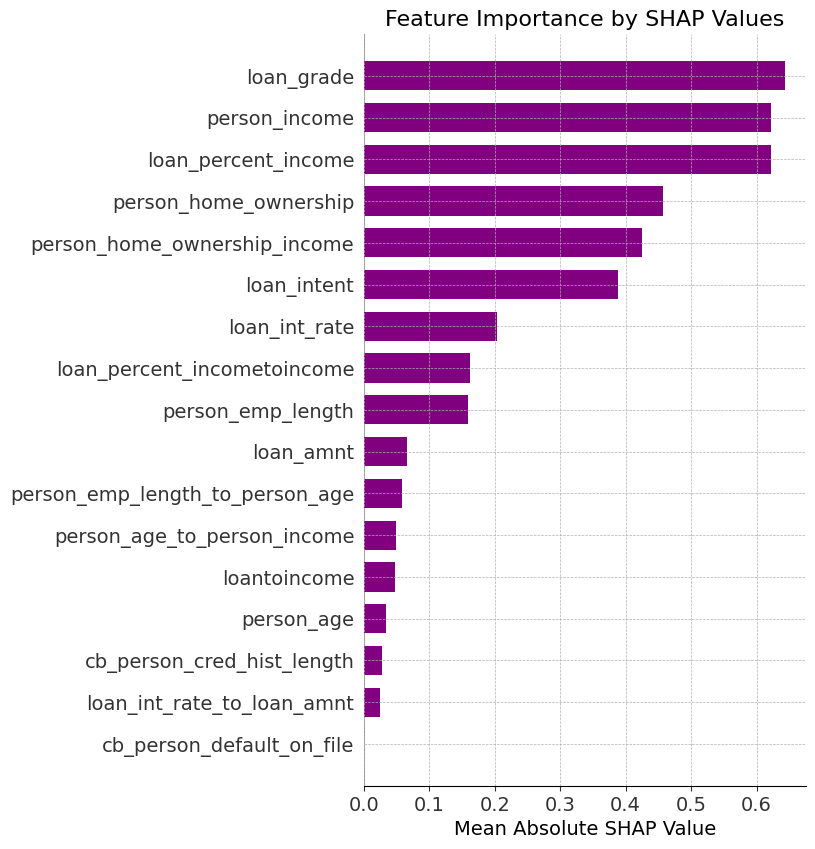

In [14]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type="bar", 
    class_names=np.unique(y_train),
    color='purple',
    show=False
)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.xlabel('Mean Absolute SHAP Value', fontsize=14) 
plt.title('Feature Importance by SHAP Values', fontsize=16) 
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5) 
plt.show()

In [15]:
## create submission
submission = test[['id']]
submission['loan_status'] = np.mean(preds, axis=0)

submission.to_csv('submission.csv', index=False)
submission

,id,loan_status
0,58645,0.959409
1,58646,0.006682
2,58647,0.329321
3,58648,0.005950
4,58649,0.061192
...,...,...
39093,97738,0.087213
39094,97739,0.001346
39095,97740,0.004797
39096,97741,0.337835
